In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
device = torch.device("cuda:0")


In [2]:
with open("datasets/tinyShakespeare.txt", "r") as f:
    load = f.read()
print(load[:200])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


In [3]:
texttoint = {elm: n for n, elm in enumerate(set(load))}
inttotext = {n:elm for n, elm in enumerate(set(load))}
dataset = [texttoint[c] for c in load]

vocab_size = len(texttoint)
sequence_length = 20

sequences = torch.tensor([dataset[i:-sequence_length+i-1] for i in range(sequence_length+1)]).T
inputs = sequences[2000:, :-1]
labels = sequences[2000:, -1]
val_inputs = sequences[:2000, :-1]
val_labels = sequences[:2000, -1]

In [4]:
vocab_size

65

In [15]:
act = F.gelu
HIDDEN_SIZE = 512

class FullyConnected(nn.Module):
    def __init__(self, in_size, out_size, hidden_size=HIDDEN_SIZE):
        super(FullyConnected, self).__init__()
        self.LayerNorm = nn.LayerNorm(in_size)

        self.fc1 = nn.Linear(in_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, out_size)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.LayerNorm(x)
        x = act(self.fc1(x))
        x = act(self.fc2(x))
        x = self.out(x)
        return x

class MoE(nn.Module):
    def __init__(self, in_size, out_size, hidden_size=HIDDEN_SIZE, depth=4, n_experts=5):
        super(MoE, self).__init__()
        self.LayerNorm = nn.LayerNorm(in_size)

        self.fcin = nn.Linear(in_size, hidden_size)
        self.experts = nn.ModuleList([nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_experts)]) for _ in range(depth)])
        self.fcout = nn.Linear(hidden_size, out_size)

    def forward(self, x, chosen_expert=None):
        x = x.view(x.shape[0], -1)
        x = self.LayerNorm(x)
        x = act(self.fcin(x))
        choice = torch.multinomial(torch.softmax(x[:, :4], 1), 1)[:, 0]
        if chosen_expert is None: # It might be that i goth this the other way around, doesnt matter if depth and n_experts are the same
            for i in range(len(self.experts)):
                for expert in self.experts[i]:
                    x[choice == i] += act(expert(x[choice == i]))
        else:
            for i in range(len(self.experts)):
                expert = self.experts[i][chosen_expert]
                x[choice == i] += act(expert(x[choice == i]))

        x = self.fcout(x)
        return x

class Attention(nn.Module):
    def __init__(self, config):
        super(Attention, self).__init__()
        self.config = config

        self.keys = nn.Linear(config.emb_size, config.head_size)
        self.queries = nn.Linear(config.emb_size, config.head_size)
        self.values = nn.Linear(config.emb_size, config.head_size)
        self.norm = nn.LayerNorm(sequence_length*config.emb_size)

    def forward(self, x):
        x = self.norm(x.view(x.shape[0], -1)).view(x.shape[0], sequence_length, self.config.emb_size)

        k = self.keys(x)     # [Batch_size, time, head_size]
        q = self.queries(x)  # [Batch_size, time, head_size]
        v = self.values(x)   # [Batch_size, time, head_size]

        similarity = k @ q.transpose(-2, -1)/(self.config.head_size**0.5)
        similarity = torch.tril(similarity)  # [Batch_size, time, time]
        similarity[similarity == 0] = float("-inf")
        similarity = torch.softmax(similarity, dim = 1)
        attention = similarity @ v    # [Batch_size, time, head_size]
        return attention

class GPTconfig():
    pass


class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.att = nn.ModuleList([Attention(config) for _ in range(config.n_heads)])
        self.MoE = MoE(in_size=sequence_length*config.head_size*config.n_heads, out_size=sequence_length*config.emb_size, n_experts=config.n_experts)


    def forward(self, x, chosen_expert=None):  # inputs: [Batch_size, time, vocab_size]
        batch_size = x.shape[0]
        
        x = torch.cat([att(x) for att in self.att], dim=1)
        x = x.view(batch_size, self.config.head_size*self.config.n_heads*sequence_length)
        x = self.MoE(x, chosen_expert).view(x.shape[0], sequence_length, self.config.emb_size)

        return x


class Model(nn.Module):
    def __init__(self, n_experts=5):
        super(Model, self).__init__()

        config = GPTconfig()
        config.vocab_size = vocab_size
        config.head_size = 20
        config.emb_size = 8
        config.n_heads = 5
        config.n_blocks = 3
        config.n_experts = n_experts
        self.config = config

        self.pemb = nn.Embedding(sequence_length, config.emb_size)
        self.wemb = nn.Embedding(config.vocab_size, config.emb_size)
        self.blocks = nn.ModuleList([Block(config) for i in range(config.n_blocks)])
        self.lout = FullyConnected(in_size=sequence_length*config.emb_size, out_size=config.vocab_size)

    def forward(self, x, chosen_expert=None):
        batch_size = x.shape[0]

        # embeddings
        pemb = self.pemb(torch.arange(sequence_length).to(device)).view(1, sequence_length, self.config.emb_size) # [time, emb_size]
        wemb = self.wemb(x)        # [Batch_size, time, emb_size]

        x = wemb + pemb
        
        for block in self.blocks:
            x = x + block(x, chosen_expert=chosen_expert)
        self.std = x.std()
        x = self.lout(x)
        return x

model = Model(n_experts=8).to(device)
lossi = []
vlossi = []
print("Millions of parameters: ", round(sum(p.numel() for p in model.parameters() if p.requires_grad)/1000000, 2))

Millions of parameters:  28.94


In [17]:
%%time
epochs = 3000
batch_size = 8192
print("Percent of dataset: ", epochs*batch_size / inputs.shape[0])

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) # everything in the forward pass happens in the model class
    loss = F.cross_entropy(pred, labels[indexes].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(loss.item())

    with torch.no_grad():
        pred = model(val_inputs.to(device))
        loss = F.cross_entropy(pred, val_labels.to(device))
        vlossi.append(loss.item())

Percent of dataset:  14.715643364802272
1.619337797164917
1.5593615770339966
1.5030622482299805


KeyboardInterrupt: 

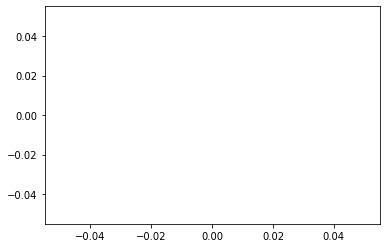

In [8]:
plt.plot(torch.tensor(lossi[::]).view(-1, 1).mean(1))

In [21]:
# val accuracy

pred = model(val_inputs.to(device))
pred = torch.argmax(pred, dim=1)
val_labels = val_labels.to(device)
acc = (pred == val_labels).float().mean()
print("Validation accuracy of MoE: ", acc)

for chosen in range(8):
    pred = model(val_inputs.to(device), chosen_expert=chosen)
    pred = torch.argmax(pred, dim=1)
    val_labels = val_labels.to(device)
    acc = (pred == val_labels).float().mean()
    print("Validation accuracy of expert", chosen, ": ", acc)


Validation accuracy of MoE:  tensor(0.5580, device='cuda:0')
Validation accuracy of expert 0 :  tensor(0.1770, device='cuda:0')
Validation accuracy of expert 1 :  tensor(0.1670, device='cuda:0')
Validation accuracy of expert 2 :  tensor(0.1705, device='cuda:0')
Validation accuracy of expert 3 :  tensor(0.1665, device='cuda:0')
Validation accuracy of expert 4 :  tensor(0.1620, device='cuda:0')
Validation accuracy of expert 5 :  tensor(0.1555, device='cuda:0')
Validation accuracy of expert 6 :  tensor(0.1540, device='cuda:0')
Validation accuracy of expert 7 :  tensor(0.1605, device='cuda:0')
